In [2]:
#importing sklearn and needed modules
!pip install -q sklearn

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from IPython.display import clear_output 
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc 
import tensorflow as tf 

Using the Titanic data set from Kaggle to predict the survival of passengers on the Titanic

Steps to take when building a model

1. Load the data
2. Explore the data
3. Catagorize the data
4. Create feature columns for the data




In [4]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
print(dftrain.head())
y_train = dftrain.pop('survived') #pop removes a column of information and saves it for later under the given variable name
y_eval = dfeval.pop('survived')
print(dftrain.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0     

In [5]:
#Explore the data
dftrain.describe() #Gives overall information on data set

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

In [6]:
dftrain.shape #Shape of data

(627, 9)

<AxesSubplot:>

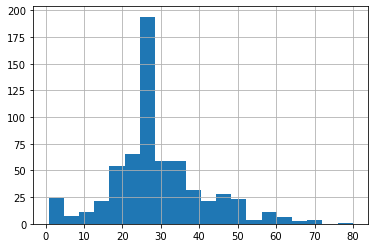

In [7]:
dftrain.age.hist(bins=20) #bins-increments of graphing

<AxesSubplot:>

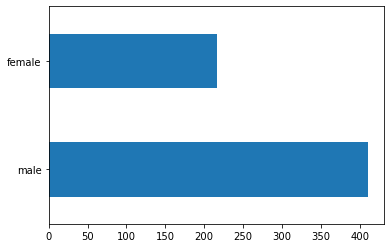

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

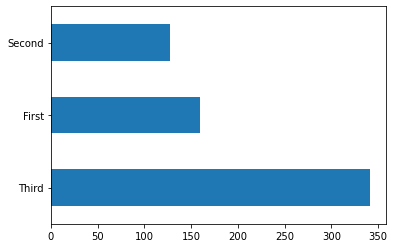

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

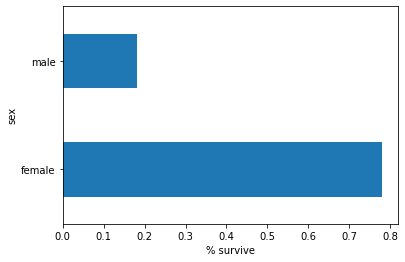

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

- <h6>Conculsion</h6>
- Most passengers are in their 20's or 30's
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival

**Training data** is what we feed to the model so that it can develop and learn. 

**Testing data** is what we use to evaulate the model and see how well it is performing. 

# Categorize the data

**Categorical data** - non-numerical data that can be placed under a specified field
- Note: Categorical data can be represented by numbers to identify the categories they belong to. (ex: Male = 1, Female = 0)

**Numerical data** - data that's represented by numbers

In [14]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [15]:
dftrain['class'].unique() #.unique() gives all of the unique values withing the dataset (the names of the different data elements)

array(['Third', 'First', 'Second'], dtype=object)

In [16]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  #Create a column of feature names with the different associated vocabulary terms
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Training process 
*  Models must be fed the data in batches
* Batches are fed according to Epochs 
  * Epochs are how many times the model will see the same data. Feeding the data to the model in variations
  Note: Over feeding the model can harm the outcome so feed it a little at a time.
  

### Input Function for Linear Regression
The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object. This means we must create a **input function** that can **convert** our current **pandas dataframe into that object.**

In [22]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) #num_epochs is 1 because we aren't training this dataset like the line above. Shuffle is False because we don't need to shuffle since we are testing it. 



### Creating the Linear Regression Model

Here we will use a **linear estimator** utilize the linear regression algorithm.


In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier through an estimator module

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model that tells the accuracy of it
#Accuracy - compares the dataset results with models predicted results to get the accuracy of the data
print(result)

0.75757575
{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.82938474, 'auc_precision_recall': 0.7624542, 'average_loss': 0.49292877, 'label/mean': 0.375, 'loss': 0.48657164, 'precision': 0.6576577, 'prediction/mean': 0.4156262, 'recall': 0.7373737, 'global_step': 200}


### Predicting the data set with the model

How to make predictions for every point in the evaluation data set




In [24]:
#Check the predictions of the model
#Here we will turn the results into a list to get a dictionary of all points and predictions
result = list(linear_est.predict(eval_input_fn))
#print(result[0])
#Here are looking for the 'probabilities' dict because it will help us to see the probability that someone will survive or won't survive
#Look for this --> {'probabilities': array([0.9108078 (<--won't survive(0)) , 0.08919217 (<-- will survive(1))]}

#Here we will print the probability of survival (1)
print(result[0]['probabilities'][0]) #Format: [passenger/data point][data set dict][outcome (survival)]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\nnsir\AppData\Local\Temp\tmp88u48dyz\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9349


To put this together we can evaluate the passengers' attributes to see if the prediction makes sense with the dfeval.loc[ ] method  

In [26]:
print(dfeval.loc[36])
print(y_eval.loc[36])
print(result[36]['probabilities'][1]) 
#This will give us the passengers details and their chance of survival and if they survived

sex                          male
age                          36.5
n_siblings_spouses              0
parch                           2
fare                         26.0
class                      Second
deck                            F
embark_town           Southampton
alone                           n
Name: 36, dtype: object
0
0.18936059


In [27]:
print(dfeval.loc[26])
print(y_eval.loc[26])
print(result[26]['probabilities'][1]) 
#This will give us the passengers details and their chance of survival and if they survived

sex                          male
age                          21.0
n_siblings_spouses              2
parch                           0
fare                         73.5
class                      Second
deck                      unknown
embark_town           Southampton
alone                           n
Name: 26, dtype: object
0
0.4572698


In [29]:
print(dfeval.loc[17])
print(y_eval.loc[17])
print(result[17]['probabilities'][1]) 
#This will give us the passengers details and their chance of survival and if they survived

sex                        female
age                          17.0
n_siblings_spouses              0
parch                           0
fare                         10.5
class                      Second
deck                      unknown
embark_town           Southampton
alone                           y
Name: 17, dtype: object
1
0.82789034
